In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf

import pathlib
import os
import cv2 as cv

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from skimage import exposure
import sys

import random
import shutil
import seaborn as sns

import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import regularizers
# from tensorflow.keras.utils import np_utils
from sklearn import metrics
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras import regularizers
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings("ignore")
# tf.enable_eager_execution()

print(tf.__version__)
# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2.6.4


> **Load Dataset**

In [2]:
train_data = pathlib.Path('/kaggle/input/breast-moz/Dataset_BUSI/train')
test_data = pathlib.Path('/kaggle/input/breast-moz/Dataset_BUSI/test')
peso= pathlib.Path('/kaggle/working/')
print(train_data)


/kaggle/input/breast-moz/Dataset_BUSI/train


In [3]:
IMAGE_SIZE = 224
Nomes = ['Benign', 'Malign', 'Normal']
i0 = 0
i1 = 0
i2 = 0
i3 = 0

num_class = 3

epoch = 80
loss_function = "sparse_categorical_crossentropy"
optimizer = Adam(learning_rate=0.0001)
num_folds = 10
batchsize = 64

# container for metrics
acc_folds = []
f1_folds = []
prec_folds = []
recall_folds = []

In [4]:
def load_data(data_directory):
  
    directories = [d for d in os.listdir(data_directory)
                   if os.path.isdir(os.path.join(data_directory, d))]
    labels = []
    images = []
    file_names = []
    for d in directories:
        label_directory = os.path.join(data_directory, d)
        file_names += [os.path.join(label_directory, f)
                       for f in os.listdir(label_directory)]
                       
    random.shuffle(file_names)

    for f in file_names:
        #print(f)
        img = cv.imread(f)
        img = cv.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
        dirname = os.path.split(os.path.dirname(f))[1]

        images.append(img)
        labels.append(int(dirname))

    images, labels = np.asarray(images), np.asarray(labels)
    images = images.astype('float32') / float(255)

    return images, labels

In [5]:
imagens, labels = load_data(train_data)

# **Data analizes**

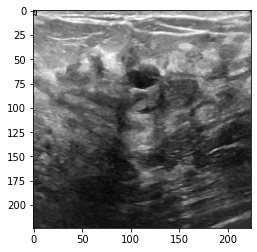

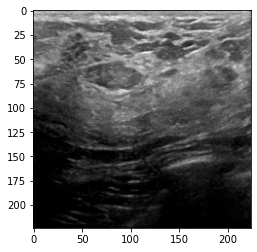

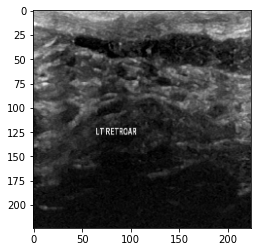

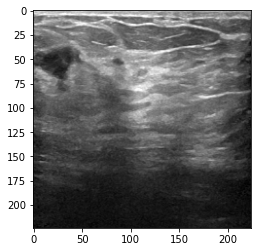

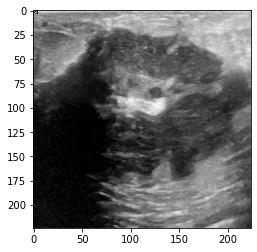

In [6]:
imagens.shape
for x in range(0,5):
  plt.figure()
  plt.imshow(imagens[x])
  plt.show()

> **Split dataset**

1. A seguir o modelo eh treinado usando a tecnica de cross fold validation K-fold onde K=10.
2. O dataset eh devido em 10 subdataset e cada subdataset eh devido em traino e test
3. O desempenho em cada subdataset eh guardado
4. No final o desempenho final do modelo eh a media do desempenho em todos os 10 subdataset. 
5. Depois calculamos o desvio padrao e o intervalo de confianca sobre o desempenho do nossso modelo. 

NB: O modelo abaixo usa 

In [ ]:
def inceptionv4(num_class):
    def conv2d(x, filter, kernel_size, strides=(1, 1), padding='same'):
        x = layers.Conv2D(filters=filter, kernel_size=kernel_size,
                          use_bias=False, kernel_initializer='glorot_uniform',
                          strides=strides, padding=padding)(x)
        x = layers.BatchNormalization(axis=Channel_axis)(x)
        x = layers.Activation('relu')(x)

        return x

    def stem(img_imput):

        x = conv2d(img_imput, 32, kernel_size=(3, 3), strides=(2, 2), padding='same')
        x = conv2d(x, 32, kernel_size=(3, 3), padding='same')
        x = conv2d(x, 64, kernel_size=(3, 3), padding='same')

        x_1 = conv2d(x, 96, kernel_size=(3, 3), strides=(2, 2), padding='same')
        x_2 = layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

        x = layers.concatenate([x_1, x_2], axis=-1)

        x1 = conv2d(x, 64, kernel_size=(3, 3), padding='same')
        x1 = conv2d(x1, 96, kernel_size=(3, 3), padding='same')

        x2 = conv2d(x, 64, kernel_size=(3, 3), padding='same')
        x2 = conv2d(x2, 64, kernel_size=(3, 3), padding='same')
        x2 = conv2d(x2, 64, kernel_size=(3, 3), padding='same')
        x2 = conv2d(x2, 96, kernel_size=(3, 3), padding='same')

        x = layers.concatenate([x1, x2], axis=-1)
        x = layers.BatchNormalization(axis=Channel_axis)(x)

        x_1 = conv2d(x, 192, kernel_size=(3, 3), strides=(2, 2), padding='same')
        x_2 = layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

        x = layers.concatenate([x_1, x_2], axis=-1)
        x = layers.BatchNormalization(axis=Channel_axis)(x)
        x = tf.nn.relu(x)

        return x

    def inception_a(x):
        a1 = conv2d(x, 64, kernel_size=(1, 1), padding='same')
        a1 = conv2d(a1, 96, kernel_size=(3, 3), padding='same')
        a1 = conv2d(a1, 96, kernel_size=(3, 3), padding='same')

        a2 = conv2d(x, 64, kernel_size=(1, 1), padding='same')
        a2 = conv2d(a2, 96, kernel_size=(3, 3), padding='same')

        a3 = layers.AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
        a3 = conv2d(a3, 96, kernel_size=(1, 1), padding='same')

        a4 = conv2d(x, 96, kernel_size=(1, 1), padding='same')

        x = layers.concatenate([a1, a2, a3, a4], axis=-1)
        x = tf.nn.relu(x)

        return x

    def reduction_a(x):
        x1 = conv2d(x, 192, kernel_size=(1, 1), padding='same')
        x1 = conv2d(x1, 224, kernel_size=(3, 3), padding='same')
        x1 = conv2d(x1, 256, kernel_size=(3, 3), strides=(2, 2), padding='same')

        x2 = conv2d(x, 32, kernel_size=(3, 3), strides=(2, 2), padding='same')

        x3 = layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

        x = layers.concatenate([x1, x2, x3], axis=-1)

        x = tf.nn.relu(x)

        return x

    def inception_b(x):
        b1 = conv2d(x, 192, kernel_size=(1, 1), padding='same')
        b1 = conv2d(b1, 192, kernel_size=(7, 1), padding='same')
        b1 = conv2d(b1, 224, kernel_size=(1, 7), padding='same')
        b1 = conv2d(b1, 224, kernel_size=(7, 1), padding='same')
        b1 = conv2d(b1, 256, kernel_size=(1, 7), padding='same')

        b2 = conv2d(x, 192, kernel_size=(1, 1), padding='same')
        b2 = conv2d(b2, 224, kernel_size=(1, 7), padding='same')
        b2 = conv2d(b2, 256, kernel_size=(7, 1), padding='same')

        b3 = layers.AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
        b3 = conv2d(b3, 128, kernel_size=(1, 1), padding='same')

        b4 = conv2d(x, 384, kernel_size=(1, 1), padding='same')

        x = layers.concatenate([b1, b2, b3, b4], axis=-1)
        x = tf.nn.relu(x)

        return x

    def reduction_b(x):
        x1 = conv2d(x, 256, kernel_size=(1, 1), padding='same')
        x1 = conv2d(x1, 256, kernel_size=(1, 7), padding='same')
        x1 = conv2d(x1, 320, kernel_size=(7, 1), padding='same')
        x1 = conv2d(x1, 320, kernel_size=(3, 3), strides=(2, 2), padding='same')

        x3 = layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

        x2 = conv2d(x, 192, kernel_size=(1, 1), padding='same')
        x2 = conv2d(x2, 192, kernel_size=(3, 3), strides=(2, 2), padding='same')

        x = layers.concatenate([x1, x2, x3], axis=-1)

        x = tf.nn.relu(x)

        return x

    def inception_c(x):
        c1 = conv2d(x, 384, kernel_size=(1, 1), padding='same')
        c1 = conv2d(c1, 446, kernel_size=(3, 1), padding='same')
        c1 = conv2d(c1, 512, kernel_size=(1, 3), padding='same')
        c1_1 = conv2d(c1, 256, kernel_size=(1, 3), padding='same')
        c1_2 = conv2d(c1, 256, kernel_size=(3, 1), padding='same')

        c2 = conv2d(x, 384, kernel_size=(1, 1), padding='same')
        c2_1 = conv2d(c2, 256, kernel_size=(1, 3), padding='same')
        c2_2 = conv2d(c2, 256, kernel_size=(3, 1), padding='same')

        c3 = layers.AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
        c3 = conv2d(c3, 256, kernel_size=(1, 1), padding='same')

        c4 = conv2d(x, 256, kernel_size=(1, 1), padding='same')

        x = layers.concatenate([c1_1, c1_2, c2_1, c2_2, c3, c4], axis=-1)

        x = tf.nn.relu(x)

        return x

    img_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

    x = stem(img_input)

    for i in range(4):
        x = inception_a(x)

    x = reduction_a(x)

    for i in range(7):
        x = inception_b(x)

    x = reduction_b(x)

    for i in range(3):
        x = inception_c(x)

    x = layers.GlobalAveragePooling2D()(x)

    output = layers.Dense(num_class, activation='softmax', dtype=tf.float32)(x)

    model = models.Model(inputs=img_input, outputs=output, name='InceptionV4')

    return model

(702, 224, 224, 3)
(702,)
Epoch 1/80
11/11 [==============================] - 30s 1s/step - loss: 0.8655 - accuracy: 0.6425 - val_loss: 1.1654 - val_accuracy: 0.2692
Epoch 2/80
11/11 [==============================] - 7s 624ms/step - loss: 0.4755 - accuracy: 0.8348 - val_loss: 1.4381 - val_accuracy: 0.1667
Epoch 3/80
11/11 [==============================] - 7s 612ms/step - loss: 0.2349 - accuracy: 0.9615 - val_loss: 1.5497 - val_accuracy: 0.1667
Epoch 4/80
11/11 [==============================] - 7s 613ms/step - loss: 0.1081 - accuracy: 0.9872 - val_loss: 1.7890 - val_accuracy: 0.1667
Epoch 5/80
11/11 [==============================] - 7s 611ms/step - loss: 0.0367 - accuracy: 0.9972 - val_loss: 2.2074 - val_accuracy: 0.1667
Epoch 6/80
11/11 [==============================] - 7s 618ms/step - loss: 0.0167 - accuracy: 0.9986 - val_loss: 2.4819 - val_accuracy: 0.1667
Epoch 7/80
11/11 [==============================] - 7s 619ms/step - loss: 0.0091 - accuracy: 0.9986 - val_loss: 2.9668 - val

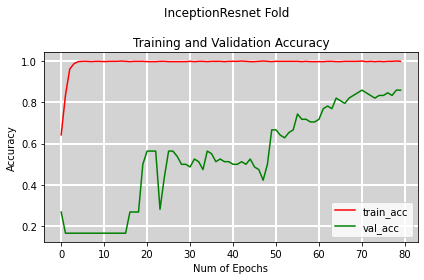

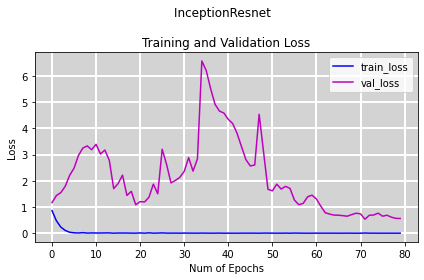

(702, 224, 224, 3)
(702,)
Epoch 1/80
11/11 [==============================] - 26s 902ms/step - loss: 1.0315 - accuracy: 0.5783 - val_loss: 1.2349 - val_accuracy: 0.2692
Epoch 2/80
11/11 [==============================] - 7s 610ms/step - loss: 0.6121 - accuracy: 0.7393 - val_loss: 1.1840 - val_accuracy: 0.2692
Epoch 3/80
11/11 [==============================] - 7s 616ms/step - loss: 0.4034 - accuracy: 0.8561 - val_loss: 1.3412 - val_accuracy: 0.2692
Epoch 4/80
11/11 [==============================] - 7s 610ms/step - loss: 0.2660 - accuracy: 0.9060 - val_loss: 0.9781 - val_accuracy: 0.5641
Epoch 5/80
11/11 [==============================] - 7s 616ms/step - loss: 0.1217 - accuracy: 0.9601 - val_loss: 1.0340 - val_accuracy: 0.5641
Epoch 6/80
11/11 [==============================] - 7s 615ms/step - loss: 0.0506 - accuracy: 0.9915 - val_loss: 1.2467 - val_accuracy: 0.2692
Epoch 7/80
11/11 [==============================] - 7s 617ms/step - loss: 0.0408 - accuracy: 0.9915 - val_loss: 1.1034 - 

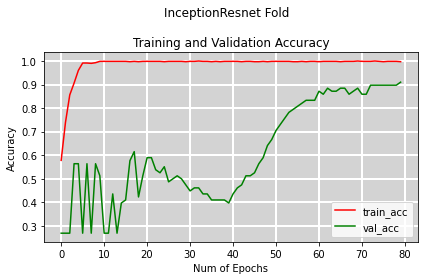

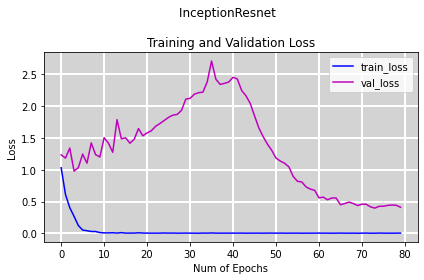

(702, 224, 224, 3)
(702,)
Epoch 1/80
11/11 [==============================] - 26s 932ms/step - loss: 1.1772 - accuracy: 0.5627 - val_loss: 1.1124 - val_accuracy: 0.2692
Epoch 2/80
11/11 [==============================] - 7s 612ms/step - loss: 0.6296 - accuracy: 0.7279 - val_loss: 1.2311 - val_accuracy: 0.2692
Epoch 3/80
11/11 [==============================] - 7s 609ms/step - loss: 0.4534 - accuracy: 0.8219 - val_loss: 1.3521 - val_accuracy: 0.2692
Epoch 4/80
11/11 [==============================] - 7s 618ms/step - loss: 0.3572 - accuracy: 0.8661 - val_loss: 1.0693 - val_accuracy: 0.2692
Epoch 5/80
11/11 [==============================] - 7s 608ms/step - loss: 0.1970 - accuracy: 0.9231 - val_loss: 0.9946 - val_accuracy: 0.5641
Epoch 6/80
11/11 [==============================] - 7s 610ms/step - loss: 0.0875 - accuracy: 0.9715 - val_loss: 1.3691 - val_accuracy: 0.5641
Epoch 7/80
11/11 [==============================] - 7s 612ms/step - loss: 0.1133 - accuracy: 0.9601 - val_loss: 1.0001 - 

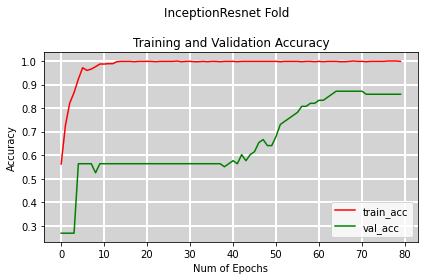

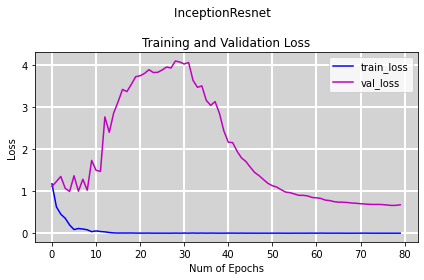

(702, 224, 224, 3)
(702,)
Epoch 1/80
11/11 [==============================] - 25s 903ms/step - loss: 1.0765 - accuracy: 0.5598 - val_loss: 1.1569 - val_accuracy: 0.2692
Epoch 2/80
11/11 [==============================] - 7s 620ms/step - loss: 0.6695 - accuracy: 0.7407 - val_loss: 1.3921 - val_accuracy: 0.2692
Epoch 3/80
11/11 [==============================] - 7s 611ms/step - loss: 0.5073 - accuracy: 0.7877 - val_loss: 1.2611 - val_accuracy: 0.2692
Epoch 4/80
11/11 [==============================] - 7s 613ms/step - loss: 0.3527 - accuracy: 0.8590 - val_loss: 1.2570 - val_accuracy: 0.2692
Epoch 5/80
11/11 [==============================] - 7s 610ms/step - loss: 0.1958 - accuracy: 0.9274 - val_loss: 1.1211 - val_accuracy: 0.5641
Epoch 6/80
11/11 [==============================] - 7s 616ms/step - loss: 0.1314 - accuracy: 0.9615 - val_loss: 1.8189 - val_accuracy: 0.2692
Epoch 7/80
11/11 [==============================] - 7s 615ms/step - loss: 0.0802 - accuracy: 0.9758 - val_loss: 1.4279 - 

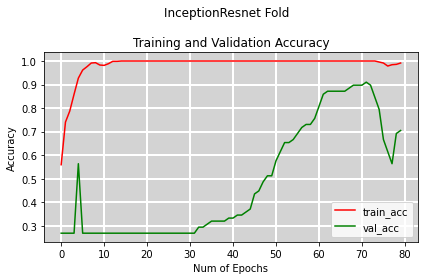

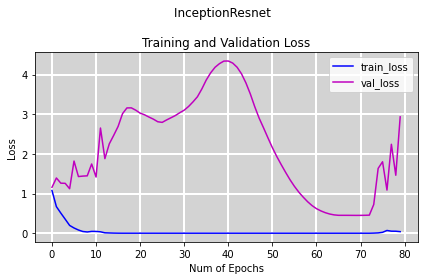

(702, 224, 224, 3)
(702,)
Epoch 1/80
11/11 [==============================] - 26s 959ms/step - loss: 1.1176 - accuracy: 0.5869 - val_loss: 1.3359 - val_accuracy: 0.2692
Epoch 2/80
11/11 [==============================] - 7s 614ms/step - loss: 0.6143 - accuracy: 0.7507 - val_loss: 1.2147 - val_accuracy: 0.2692
Epoch 3/80
11/11 [==============================] - 7s 617ms/step - loss: 0.4803 - accuracy: 0.8191 - val_loss: 1.0424 - val_accuracy: 0.5641
Epoch 4/80
11/11 [==============================] - 7s 610ms/step - loss: 0.3022 - accuracy: 0.8932 - val_loss: 1.1544 - val_accuracy: 0.2692
Epoch 5/80
11/11 [==============================] - 7s 611ms/step - loss: 0.1881 - accuracy: 0.9245 - val_loss: 1.2006 - val_accuracy: 0.2692
Epoch 6/80
11/11 [==============================] - 7s 613ms/step - loss: 0.0949 - accuracy: 0.9658 - val_loss: 1.0774 - val_accuracy: 0.2692
Epoch 7/80
11/11 [==============================] - 7s 613ms/step - loss: 0.1165 - accuracy: 0.9644 - val_loss: 0.9965 - 

In [ ]:


kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=29)
indice = 0

for train, test in kf.split(imagens, labels):
    imgs_train, imgs_val = imagens[train], imagens[test]
    labs_train, labs_val = labels[train], labels[test]
    
    print(imgs_train.shape)
    print(labs_train.shape)
     
        
    model = inceptionv4(num_class)

    #Compilar modelo

    # model.summary()
    model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])
    icept = model.fit(imgs_train, labs_train,batch_size=batchsize,validation_data=(imgs_val, labs_val), verbose=1,epochs=epoch)
    
    print(imgs_val.shape)
    print(labs_val.shape)

    labs_predict = model.predict(imgs_val)
    labs_predict = np.argmax(labs_predict, axis=1)

    accuracy = metrics.accuracy_score(labs_val, labs_predict)
    acc_folds.append(accuracy)

    f1 = metrics.f1_score(labs_val, labs_predict, average="macro")
    f1_folds.append(f1)

    precision = metrics.precision_score(labs_val, labs_predict, average="macro")
    prec_folds.append(precision)

    recall = metrics.recall_score(labs_val, labs_predict, average="macro")
    recall_folds.append(recall)

    print('Acurracy: %f' % accuracy)
    print('F1: %f' % f1)
    print('Precision: %f' % precision)
    print('Recall: %f' % recall)

    print("==========================================================================")
    plt.figure(0)
    plt.plot(icept.history['accuracy'], 'r', label="train_acc")
    plt.plot(icept.history['val_accuracy'], 'g', label="val_acc")
    plt.xlabel("Num of Epochs")
    plt.ylabel("Accuracy")
    plt.yscale('linear')
    plt.xscale('linear')
    plt.title("InceptionResnet Fold  \n \n"
                  "Training and Validation Accuracy")
    plt.tight_layout()
    plt.legend(loc='upper right')
    plt.grid(True, color='w', linestyle='-', linewidth=2)
    plt.gca().patch.set_facecolor('lightgrey')
    plt.legend()
    plt.savefig(str(peso) + '/InceptionAcc.png')
    plt.show()
    plt.close()

    plt.figure(1)
        
    plt.plot(icept.history['loss'], 'b', label="train_loss")
    plt.plot(icept.history['val_loss'], 'm', label="val_loss")
    plt.xlabel("Num of Epochs")
    plt.ylabel("Loss")
    plt.yscale('linear')
    plt.xscale('linear')
    plt.title("Inception \n \n"
                  "Training and Validation Loss")
    plt.tight_layout()
    plt.legend(loc='upper right')
    plt.grid(True, color='w', linestyle='-', linewidth=2)
    plt.gca().patch.set_facecolor('lightgrey')
    plt.legend()
    plt.savefig(str(peso) + '/InceptionVal.png')
    plt.show()
    
    hist_df = pd.DataFrame(icept.history)
    hist_csv_file = '/kaggle/working/Inception' + str(indice) + '.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)
    
    indice += 1
    
    model = None
    imgs_train = None
    labs_train = None
    imgs_val = None
    labs_val = None


print("===================================================================")
print(f'> Global accuracy: {np.mean(acc_folds)} {np.std(acc_folds)}')
print(f'> Global F1_Score:  {np.mean(f1_folds)} {np.std(f1_folds)}')
print(f'> Global Precision: {np.mean(prec_folds)} {np.std(prec_folds)}')
print(f'> Global Recall:  {np.mean(recall_folds)} {np.std(recall_folds)}')
print("===================================================================")

print("Acuracia", acc_folds)
print("===================================================================")
print("F1 Score", f1_folds)
print("===================================================================")
print("Precision", prec_folds)
print("===================================================================")
print("Recall", recall_folds)

# # **Model Test on Test Set**

Se quiser ver o desempenho do modelo no test set deve
1. Train o modelo em todo training set( sem usar K-fold cross validation dessa vez)
2. Testar o teu modelo no test set
3. O Desempenho do teu modelo deve estar dentro do intervalo de confia definido pelo K-fold

In [ ]:
# model = tf.keras.applications.xception.Xception( weights=None,
#                                                 input_shape=(IMAGE_SIZE, IMAGE_SIZE,3), classes=3, classifier_activation='softmax')

# #Compilar modelo

# # model.summary()

# model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

# xcept = model.fit(imagens, labels,batch_size=batchsize, verbose=1,epochs=epoch)

In [ ]:
# #Load Test data

# imgs_test, labs_test = load_data(test_data)
# print(imgs_test.shape)
# print(labs_test.shape)

# labs_predict = model.predict(imgs_test)
# labs_predict = np.argmax(labs_predict, axis=1)

# accuracy = metrics.accuracy_score(labs_test, labs_predict)
# f1 = metrics.f1_score(labs_test, labs_predict, average="macro")
# precision = metrics.precision_score(labs_test, labs_predict, average="macro")
# recall = metrics.recall_score(labs_test, labs_predict, average="macro")

# print('Acurracy: %f' % accuracy)
# print('F1: %f' % f1)
# print('Precision: %f' % precision)
# print('Recall: %f' % recall)